In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nn.layers.transformer import Transformer
from nn.losses.classification import CategoricalCrossentropy
from nn.optimizers.first_order import Adam

with open("../data/resources/saved_datasets/tiny_shakespeare.txt", "r") as f:
    o = f.read().splitlines()

datastr = " ".join(o).lower()#[:100]
split = int(0.8 * len(datastr))
train = datastr[:split]
val   = datastr[split:]
#datastr = "abcd"
#train = 1000*"abc"
#val = 1000*"bcd"
vocab = sorted(list(set(datastr)))

def sample_data(example_len, data):
    start_idx = np.random.randint(len(data)-example_len)
    example = data[start_idx:start_idx+example_len]
    return np.array([vocab.index(c) for c in example])

def generate_batch(batch_size, block_size, data):
    data = np.array([sample_data(block_size+1, data) for _ in range(batch_size)])
    decoder_inputs = data[:, :-1]
    targets        = data[:, 1:]
    encoder_inputs = np.ones_like(decoder_inputs)
    return encoder_inputs, decoder_inputs, targets

block_size = 32                 # sequence length
batch_size = 128                # batch size
d_model = 32                    # dimesion of embedding
d_ff = d_model*2                # FF projection dimension
n_heads = 8                     # number of attention heads
d_hidden = d_model // n_heads   # attention dimension
n_layers = 2                    # number of encoder and decoder layers
vocab_size = len(vocab)         # size of vocabulary

np.random.seed(1337)

model = Transformer(vocab_size, n_layers, n_heads, d_model, d_hidden, d_ff)
loss  = CategoricalCrossentropy()
optim = Adam(model.parameters(), 1e-2, 0.9, 0.999)
history = {"train": [], "val": []}

print(model.n_params())

44902


In [2]:
np.random.seed(1337)

steps = 10000
log_step = 10
for s in range(steps):
    optim.zero_grad()

    # forward pass
    x_enc, x_dec, y = generate_batch(batch_size, block_size, train)
    y_pred = model([x_enc, x_dec])
    l = loss.calculate(y, y_pred)
    history["train"].append(l)

    # backward + optimization step
    model.backward(loss.backward())
    optim.step()

    if s % log_step == 0:
        x_enc, x_dec, y = generate_batch(batch_size*10, block_size, val)
        y_pred = model([x_enc, x_dec])
        l = loss.calculate(y, y_pred)
        history["val"] += log_step * [l]
        print(f"step: {s}, train loss: {np.mean(history['train'][-log_step:]):.3f}, val loss: {l:.3f}")

print(f"min loss: {min(history['train'])}")

step: 0, train loss: 8.054, val loss: 7.252
step: 10, train loss: 5.576, val loss: 4.188
step: 20, train loss: 4.017, val loss: 3.749
step: 30, train loss: 3.607, val loss: 3.491
step: 40, train loss: 3.409, val loss: 3.326
step: 50, train loss: 3.265, val loss: 3.212
step: 60, train loss: 3.183, val loss: 3.140
step: 70, train loss: 3.114, val loss: 3.098
step: 80, train loss: 3.072, val loss: 3.047
step: 90, train loss: 3.039, val loss: 3.020
step: 100, train loss: 3.008, val loss: 2.997
step: 110, train loss: 2.994, val loss: 2.984
step: 120, train loss: 2.988, val loss: 2.985
step: 130, train loss: 2.979, val loss: 2.984
step: 140, train loss: 2.993, val loss: 2.975
step: 150, train loss: 2.975, val loss: 2.977
step: 160, train loss: 2.977, val loss: 2.969
step: 170, train loss: 2.978, val loss: 2.973
step: 180, train loss: 2.975, val loss: 2.970
step: 190, train loss: 2.983, val loss: 2.973
step: 200, train loss: 2.982, val loss: 2.976
step: 210, train loss: 2.976, val loss: 2.968

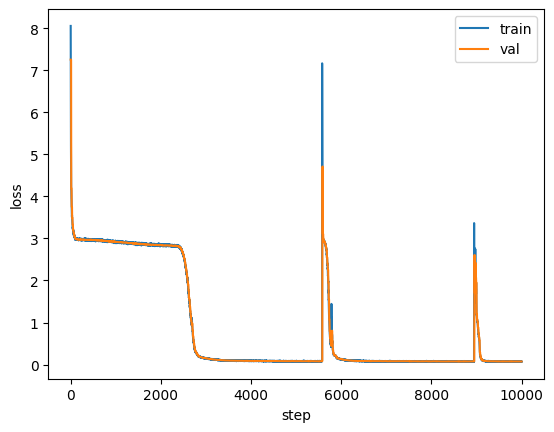

In [6]:
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.savefig("../figs/loss.png")

In [4]:
np.random.seed(1337)

def sample_multinomial(p):
    # source: https://stackoverflow.com/questions/40474436/how-to-apply-numpy-random-choice-to-a-matrix-of-probability-values-vectorized-s
    cumsum = p.cumsum(axis=-1)
    draws = np.random.rand(*cumsum.shape[:-1], 1)
    return (draws < cumsum).argmax(axis=-1)

def sample_top(p):
    return p.argmax(axis=-1)

def generate_tokens(x_seed, out_len, sampling_fcn):
    x_enc, x_dec = x_seed
    for _ in range(out_len):
        y_pred = model([x_enc, x_dec])
        y_pred = sampling_fcn(y_pred)[..., -1]
        x_dec[..., :-1] = x_dec[..., 1:]
        x_dec[..., -1] = y_pred
        yield vocab[y_pred]

x_enc, x_dec, _ = generate_batch(1, block_size, val)

print("seed tokens:                        |", "".join([vocab[i] for i in x_dec[0]]))
print("sampling predicted distribution:    |", "".join([t for t in generate_tokens([x_enc[0], x_dec[0]], 100, sample_multinomial)]))
print("greedy:                             |", "".join([t for t in generate_tokens([x_enc[0], x_dec[0]], 100, sample_top)]))

seed tokens:                        | t'st on many a thousand grains t
sampling predicted distribution:    | hoh shoor atins, ich the mpeit thatecket dethat hi whiuech wooy slertean: dow than's te! hheem ges y
greedy:                             | ou the the the the the the the the the the the the the the the the the the the the the the the the t
